# Tutorial：1 
- 使用フレームワーク : deap
- 選択手法 : NSGA-Ⅱ
- 設計変数 : 2個
  - 連続値 : 2個
- 目的変数 : 2個
- 制約条件 : 1パターン
    1. 連続値のmin,max 

## 習得してもらうこと
- deapの使い方
- NSGA-Ⅱの場合の流れ
- 設計変数が連続値である時の扱い方
- 制約条件が連続値のmin, maxの場合の扱い方

## 実施内容
 - Part0. 取り扱う問題設定

 - Patr1: モジュールのimport 

 - Part2: 評価関数の作成
   - 目的関数の設計
   - ペナルティ関数の導入


 - Part3: 遺伝的アルゴリズムの設計
   - 遺伝的アルゴリズムにおける個体の表現
   - 遺伝子操作関数の設定
     - 交叉
     - 突然変異
   - 解の選択手法の設定


 - Part4: 最適化計算の実行
   - 初期状態の設定
   - 遺伝的最適化計算の実行  


 - Part5. 結果の確認
   - 初期世代と最終世代の目的関数の値を確認
   - 制約条件を満たした値であるか確認
   - ハイパーボリューム

# Part0. 取り扱う問題設定

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 \\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 \\
&s.t.& 0& \leqq  A  \leqq 5 \\
& & 0& \leqq  B  \leqq 3
\end{align*}
$

# Part1. モジュールのimport

In [1]:
%load_ext lab_black

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from deap import base, creator, tools
from deap.benchmarks.tools import hypervolume

# Part2. 評価関数の作成

#### 進化計算における評価関数は二つの要素からなります

- 最適解を見つけたい目的関数
- 設計変数が制約を満たさない時に淘汰されるように設定するペナルティ関数

### 目的関数
- 目的変数のf1, f2 を最小化する多目的最適化問題を解きます

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 \\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2
\end{align*}
$

In [3]:
# 評価関数
def objectfunction(individual):
    """
    individual(list): 個体の設計変数を格納するlist
    """

    # 教材用として、A, Bの変数を作成
    A = individual[0]
    B = individual[1]

    f1 = 4 * A ** 2 + 4 * B ** 2
    f2 = (A - 5) ** 2 + (B - 5) ** 2

    return f1, f2

### ペナルティ関数

- 各個体の遺伝子（変数）が制約条件の範囲外にある場合、次世代に個体が残らないようにペナルティ関数を用いて淘汰します

$ 
\begin{align*}
&s.t.& 0 \leqq  & A  \leqq 5 \\
& & 0 \leqq  & B  \leqq 3
\end{align*}
$

In [4]:
# ペナルティ関数で判定したい制約条件のリスト
# 教材用にこちらで定義していますが。後ほど登場する「generator_config」から作れるようにした方が良いです
cases = [
    {
        "type": "minmax",
        "case": {
            0: {"min": 0, "max": 5},  # 設計変数:A
            1: {"min": 0, "max": 3},  # 設計変数:B
        },
    },
]

In [5]:
# ペナルティ関数で使用する関数
# 連続値の範囲制約
def judgeminmax(individual, case):
    for k, v in case.items():
        if not float(v["min"]) <= individual[int(k)] <= v["max"]:
            return False
    return True


# ペナルティ関数用の条件判定関数 - 他の条件が出来た時にfor文内に追記することで対応可
def judge(individual, cases):
    """
    individual(list): 個体の設計変数を格納するlist
    cases(list): 判定したい条件のlist. 各条件はdict型
    """

    for case in cases:
        if case["type"] == "minmax":
            if not judgeminmax(individual, case["case"]):
                return False
    return True

### ペナルティ関数導入手順

- `個体が制約条件を満たしているか判断する関数feasible`をtoolboxに登録
- 登録したばかりの`feasible`を使用したペナルティ関数`DeltaPenality`をデコレート（関数の修飾）


#### ペナルティ関数`DeltaPenality`とは
- deapに用意されているペナルティ関数
- [DeltaPenalitについて-deap公式のリンク](https://deap.readthedocs.io/en/master/tutorials/advanced/constraints.html)
- ペナルティ関数は、**個体が制約条件を満たしているか判断する関数**と  
  **満たさないときに与える適応度**の二つを引数にして、制約条件を付けています

- `DeltaPenality`では個体が制約条件を満たしているか判断する関数`feasible`,  
  制約を満たさない時に与える適合度`delta`を与えています
 

In [6]:
# ペナルティ関数の罰則値(適応度)
distance = (1000, 1000)

# 評価関数を作成
toolbox = base.Toolbox()
toolbox.register("evaluate", objectfunction)
toolbox.register("feasible", judge, cases=cases)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, delta=distance))

#### 制約条件を満たさない個体に対しての評価について
- `distance = (1000, 1000)`はペナルティ関数を使用する際に、制約条件を満たさない個体に対して罰則として与える値（評価値）です
- 個体を選択する際に淘汰されるように、意図的に大きな値（評価値）を設定する必要があります

##### base.Toolbox.register()関数
- `base.Toolbox.register()`関数を使うと、引数のデフォルト値がない関数に、デフォルト値を設定することが出来ます
- 第2引数で指定する関数に、第3引数以降で指定するデフォルト値を設定して、第1引数で指定する名前で`base.Toolbox`内に新しく関数を作成出来ます

# Part.3 遺伝的アルゴリズムの設計

#### deapでは遺伝的アルゴリズムに必要となる要素を関数の形で登録して、遺伝的アルゴリズムを設計する必要があります

#### 必要な要素は以下の3つ

- 評価関数　←　Part2で実装済み
- 個体を格納するデータ構造
- 遺伝子操作関数

## 遺伝的アルゴリズムにおける個体の表現
### 遺伝的アルゴリズムでは、各個体は以下の情報を持っている必要があります
- 解の設計変数(遺伝子)
- 解の目的変数(適合度)

### 型指定 - creator.create()関数
- 遺伝子（設計変数）のセットを表す個体を定義するのに、`creator`というモジュールが用意されており、複雑な構造を表現が可能
1. `creator.create()`関数を使うと、listに適応度(fitness)を保存するメンバ変数を、簡単に追加できる
2. `creator.create()`関数は、あるクラスにメンバ変数を追加して子クラスを新たに作成する関数
3. `creator.create()`関数を使うときは、少なくとも２個の引数を指定する必要あり

#### 適応度の定義
- `creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))`  
  - `base.Fitness`クラスを継承
  - `weights=(-1.0, -1.0)`というメンバ変数を追加　（2つの適応度(目的関数)を最小化にする設定）
  - ちなみに、1.0が最大化、-1.0が最小化の意味を表します
  - `FitnessMin`という適応度を表すクラスを`creator`モジュール内に作成
- 以下のような関数が作られると思ってください
```python
class FitnessMin(base.Fitness):
    weights = (-1.0, -1.0)
```

### 個体の定義
- `creator.create("Individual", list, fitness=creator.FitnessMin)`
  - `list`クラスを継承 
  - `fitness=creator.FitnessMin`というメンバ変数を追加
  - `Individual`クラスを作成

- 以下のような関数が作られると思ってください
```python
class Individual(list):
    def __init__(self):
        self.fitness = FitnessMin()
```


In [7]:
# 適合度を最小化することで最適化されるような適合度クラスの作成
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# 個体クラスIndividualを作成
creator.create("Individual", list, fitness=creator.FitnessMin)

### 制約条件を満たした初期値設定

$ 
\begin{align*}
&s.t.& 0 \leqq  & A  \leqq 5 \\
& & 0 \leqq  & B  \leqq 3
\end{align*}
$



In [8]:
# 個体を作成する制約条件を記載したのdictを作成
generator_config = {
    # 使用するカラム
    "columns": ["A", "B"],
    # 各連続値の作成条件
    "variables": {
        "A": {"type": "real", "values": {"min": 0, "max": 5}},
        "B": {"type": "real", "values": {"min": 0, "max": 3}},
    },
    # 突然変異で使うカラムの指定
    "mutate_real_col": ["A", "B"],
    # 連続値のカラム
    "independent_real_col": ["A", "B"],
}

### 初期サンプルの生成関数

#### 進化計算で使用する個体の初期サンプルを、制約条件を満たすようにランダムに生成します

- 自作のサンプルの生成関数と、制約条件から、初期サンプルをlistで生成
- 生成したlistを個体世のデータ型`creator.Individual`に格納

deapでは上記の処理のための関数`initIterate`, `initRepeat`が用意されています

In [9]:
# 個体を生成する関数
def generator(generator_config):
    """
    generator_config (dict): 個体を作成する制約条件が記載されたdict
    """

    var = generator_config["variables"]

    # 連続値のサンプルを生成する.
    variables = {
        k: random.uniform(v["values"]["min"], v["values"]["max"])
        for k, v in var.items()
    }

    return [variables[col] for col in generator_config["columns"]]


# [お試し]このように作成されます
# generator(generator_config)

#### 遺伝子を作成する関数
- `toolbox.register("generator", generator, generator_config)`
  - `generator`という関数のデフォルト値に`generator_config`を指定
  - `generator`という名前の関数を作成
  
#### 個体を作成する関数
- `toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.generator)`
  - `tools.initIterate`は、2つの引数`container`、`generator`を持っており、個体を生成する`generator`関数を、個体の保存先`container`につっこんでいる
  - `toolbox.generator`を実行し、その値を`creator.Individual`に格納して返す関数`individual`を作成  
  
#### 世代を作成する関数
- `toolbox.register("population", tools.initRepeat, list, toolbox.individual)`
  - 個体を`toolbox.individual`で作成してlistに格納し、世代を生成する`population`関数を作成

In [10]:
# 遺伝子を生成する関数"generator"を登録
toolbox.register("generator", generator, generator_config)
# 個体を生成する関数”individual"を登録
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.generator)
# 個体集団を生成する関数"population"を登録
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## 遺伝子操作関数

#### 進化計算で重要な役割を持つ遺伝子操作を行う関数を生成

- deap公式の交叉・突然変異の関数を使う

### 交叉

1. 交叉関数 : `cxTwoPoint` [deap公式のリンク](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxTwoPoint)　[github](https://github.com/DEAP/deap/blob/d328fe6b68e7528b2d2d990bb2ab1ad1786e6f58/deap/tools/crossover.py#L37)
- 引数
  - ind1 : 親個体１
  - ind2 : 親個体２

In [11]:
# # 二点交叉 - 交叉に使用する関数
# def cxTwoPoint(ind1, ind2):
#     size = min(len(ind1), len(ind2))
#     cxpoint1 = random.randint(1, size)
#     cxpoint2 = random.randint(1, size - 1)
#     # 配列の位置を指定するための処理
#     if cxpoint2 >= cxpoint1:
#         cxpoint2 += 1
#     else:  # Swap the two cx points
#         cxpoint1, cxpoint2 = cxpoint2, cxpoint1

#     # 指定の位置にある値を入れ替え (交叉する)
#     ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
#         = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]

#     return ind1, ind2

In [12]:
# 交叉を行う関数"mate"を登録
toolbox.register("mate", tools.cxTwoPoint)

### 突然変異

2. 変異関数 : `mutPolynomialBounded` [deap公式のリンク](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutPolynomialBounded)　[github](https://github.com/DEAP/deap/blob/d328fe6b68e7528b2d2d990bb2ab1ad1786e6f58/deap/tools/mutation.py#L51)
- 引数
  - eta   : 突然変異の混雑度
  - low   : 突然変異を行う設計変数の最小値
  - up    : 突然変異を行う設計変数の最大値
  - indpb : 独立した設計変数（遺伝子の個体）が突然変異する確率

In [13]:
# # 突然変異に使用する関数
# def mutPolynomialBounded(individual, eta, low, up, indpb):
#     from itertools import repeat
#     try:
#         from collections.abc import Sequence
#     except ImportError:
#         from collections import Sequence

#     size = len(individual)
#     if not isinstance(low, Sequence):
#         low = repeat(low, size)
#     elif len(low) < size:
#         raise IndexError("low must be at least the size of individual: %d < %d" % (len(low), size))
#     if not isinstance(up, Sequence):
#         up = repeat(up, size)
#     elif len(up) < size:
#         raise IndexError("up must be at least the size of individual: %d < %d" % (len(up), size))

#     for i, xl, xu in zip(range(size), low, up):
#         # 突然変異を起こすか？
#         if random.random() <= indpb:
#             x = individual[i]
#             delta_1 = (x - xl) / (xu - xl) # (値 - 下限) / (上限 - 下限)
#             delta_2 = (xu - x) / (xu - xl) # (上限 - 値) / (上限 - 下限)
#             rand = random.random()
#             mut_pow = 1.0 / (eta + 1.) # 1 / (混雑度 + 1)

#             if rand < 0.5:
#                 xy = 1.0 - delta_1
#                 val = 2.0 * rand + (1.0 - 2.0 * rand) * xy ** (eta + 1)
#                 delta_q = val ** mut_pow - 1.0
#             else:
#                 xy = 1.0 - delta_2
#                 val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * xy ** (eta + 1)
#                 delta_q = 1.0 - val ** mut_pow

#             x = x + delta_q * (xu - xl)
#             x = min(max(x, xl), xu) # 上限と下限を超えてないか確認。超えた場合は、引っかかった方の値に
#             individual[i] = x
#     return individual,

#### 各設計変数ごとに突然変異が適応できる用にする関数
- 設計変数ごとで条件が違ったり、typeが違ったりして、適切な手法が異なる
- 変数ごとに適切な変異を行う必要がある

In [14]:
# 突然変異用のdict作成する関数
def muconfig(constrain_dict):
    """
    constrain_dict(dict):制約条件格納dict
    """

    cols = constrain_dict["columns"]  # 現状のカラム
    variables = constrain_dict["variables"]  # min-max等、その変数の取れる値

    mur = constrain_dict["mutate_real_col"]  # 突然変異するカラム
    cxr = constrain_dict["independent_real_col"]  # 連続値のカラム

    mu_real_index = [cols.index(c) for c in cxr if c in mur]  # 連続値のindex

    mu_low = [
        constrain_dict["variables"][col]["values"]["min"] for col in cxr if col in mur
    ]  # 連続値の下限

    mu_up = [
        constrain_dict["variables"][col]["values"]["max"] for col in cxr if col in mur
    ]  # 連続値の上限

    for mi, ma in zip(mu_low, mu_up):  # 上限と下限が逆転していないか？イコールになっていないか？
        if not mi <= ma:
            raise MutateionError("some low values higher than ups values")

    mucfg = {}
    mucfg["real_indexs"] = mu_real_index  # 連続値に対する設計変数のindex
    mucfg["lows"] = mu_low  # 連続値に対する設計変数の最小値
    mucfg["ups"] = mu_up  # 連続値に対する設計変数の最大値

    return mucfg

In [15]:
# 突然変異用のdice作成
mucfg = muconfig(generator_config)
mucfg

{'real_indexs': [0, 1], 'lows': [0, 0], 'ups': [5, 3]}

In [16]:
# 各変数ごとに分けて突然変異をするための関数
def mutation(individual, realmut, real_indexs, lows, ups, indpb=None):
    """
    individual (list): 個体のlist
    realmut(function): 親個体, lows, ups, indpbを引数にとる変異関数
    real_index(list): 設計変数の連続値のindexのlist
    lows (list): 連続値の最小値
    ups(list): 連続値の最大値
    indpb(float): 各変数に対して変異を行うか否かの確率、デフォルト値はNone. 0 <= indpb <= 1.
    """

    if not isinstance(real_indexs, list):
        raise CrossoverError(
            f'argment "real_indexs" must be list but inputed {type(real_indexs)}'
        )

    if not isinstance(lows, list):
        raise MutateionError(f"argment lows must be  list but {type(lows)}")
    if not isinstance(ups, list):
        raise MutateionError(f"argment ups must be  list but {type(ups)}")

    if not (len(real_indexs) == len(lows) and len(real_indexs) == len(ups)):
        raise MutateionError("not match lows, ups ,or real_indexs length")

    if indpb is None:
        indpb = 1 / len(real_indexs)

    # 連続値の染色体を抽出
    real_chromosome = [individual[i] for i in real_indexs]
    # 変異を実施
    real_chromosome = realmut(real_chromosome, low=lows, up=ups, indpb=indpb)[0]
    for i, r in zip(real_indexs, real_chromosome):
        individual[i] = r

    return (individual,)

In [17]:
# deapにある突然変異関数を用意
realmut = partial(tools.mutPolynomialBounded, eta=20)

# 突然変異を行う関数"mutate"を登録
toolbox.register("mutate", mutation, realmut=realmut, **mucfg)

## 解の選択（世代交代）手法

#### 親個体と生成した子個体の中から良い個体を残し、悪い個体を淘汰します
#### 今回は、NSGAⅡの選択手法を用います

- [selNSGA2について_deap公式](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selNSGA2)
- [selNSGA2の動作ついて_github](https://github.com/DEAP/deap/blob/d328fe6b68e7528b2d2d990bb2ab1ad1786e6f58/deap/tools/emo.py#L15)

In [18]:
# 個体選択法"select"を登録
toolbox.register("select", tools.selNSGA2)

# Part.4 最適化計算の実行

#### 初期状態の設定

- 初期サンプル（第一世代）の生成
- 適合度割当
- 計算過程追跡の準備 <- ログを出力する場合

In [19]:
random.seed(1)

NGEN = 50  # 繰り返し世代数
MU = 100  # 集団内の個体数
CXPB = 0.9  # 交叉率
MUTPB = 1  # 変異率

# # 世代ループ中のログに何を出力するかの設定 コメントアウトを外したらログが出力します
# stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("min", np.min, axis=0)
# stats.register("max", np.max, axis=0)

# logbook = tools.Logbook()
# logbook.header = "gen", "evals", "min", "max"

# 第一世代の生成
pop = toolbox.population(n=MU)
pop_init = pop[:]

invalid_ind = []
for ind in pop:
    if not ind.fitness.valid:
        invalid_ind.append(ind)

fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
pop = toolbox.select(pop, len(pop))

# record = stats.compile(pop)
# logbook.record(gen=0, evals=len(invalid_ind), **record)

#### 最適計算の実行
- for文を使いN次元まで行う。次世代に残すサンプルを交叉や変異し、選択して決めていく
    1. 子母集団の作成
    2. 交叉するものをランダムで選ぶ（交叉率でどのくらいが対象かを決定）
    3. 突然変異を起こす
    4. 交叉or突然変異させた個体の適応度の再評価を行う
    5. 次世代に残す個体を選択

In [20]:
# print(logbook.stream)

# 最適計算の実行
for gen in range(1, NGEN):
    # 子母集団生成
    offspring = tools.selTournamentDCD(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    # 交叉と突然変異
    ## 偶数番目と奇数番目の個体を取り出し交叉
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        # 交叉させる個体を厳選
        if random.random() <= CXPB:
            # 交叉
            toolbox.mate(ind1, ind2)

        # 突然変異
        if random.random() <= MUTPB:
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)

        # 交叉と突然変異させた個体は適応度を削除する
        del ind1.fitness.values, ind2.fitness.values

    # 適応度を削除した個体について適応度の再評価を行う
    invalid_ind = []
    for ind in offspring:
        if not ind.fitness.valid:
            invalid_ind.append(ind)

    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # 次世代を選択
    pop = toolbox.select(pop + offspring, MU)

#     record = stats.compile(pop)
#     logbook.record(gen=gen, evals=len(invalid_ind), **record)
#     print(logbook.stream)

# Part5. 結果の確認

## 初期世代と最終世代の目的関数の値を確認
- matplotlibを使って、世代ごとの目的関数の値を確認していく
- 青が初期世代、赤が最終世代となる

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 \\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2
\end{align*}
$

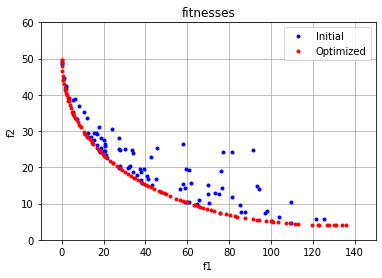

In [21]:
# 目的関数の値を確認
fitnesses_init = np.array(
    [list(pop_init[i].fitness.values) for i in range(len(pop_init))]
)
fitnesses = np.array([list(pop[i].fitness.values) for i in range(len(pop))])
# グラフで確認
plt.plot(fitnesses_init[:, 0], fitnesses_init[:, 1], "b.", label="Initial")  # 初期世代
plt.plot(fitnesses[:, 0], fitnesses[:, 1], "r.", label="Optimized")  # 最終世代
plt.legend(loc="upper right")
plt.title("fitnesses")
# 初期の例外値が残っているのでグラフ範囲を指定
plt.xlim(-10, 150)
plt.ylim(0, 60)
plt.xlabel("f1")
plt.ylabel("f2")
plt.grid(True)

## 制約条件を満たした値であるか確認
- 今回使用した連続値 A, Bが制約条件を満たしていたか確認

$ 
\begin{align*}
&subject　to& 0 \leqq  & A  \leqq 5 \\
& & 0 \leqq  & B  \leqq 3
\end{align*}
$

Aの範囲:  0.013106172426273766 4.999291913553918
Bの範囲:  0.017241658777139346 2.999954207812095


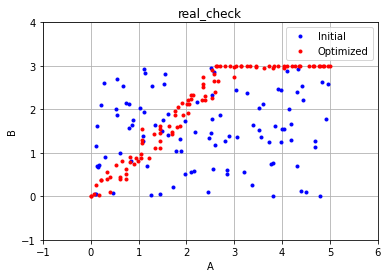

In [22]:
# 連続値がmin, maxの制約条件に従っているか確認
real_init = np.array([list(pop_init[i]) for i in range(len(pop_init))])
real = np.array([list(pop[i]) for i in range(len(pop))])
# 最大値と最小値を確認
print("Aの範囲: ", min(real[:, 0]), max(real[:, 0]))  # 0 <= A <= 5
print("Bの範囲: ", min(real[:, 1]), max(real[:, 1]))  # 0 <= B <= 3
# グラフでも確認
plt.plot(real_init[:, 0], real_init[:, 1], "b.", label="Initial")  # 初期世代
plt.plot(real[:, 0], real[:, 1], "r.", label="Optimized")  # 最終世代
plt.legend(loc="upper right")
plt.title("real_check")
plt.xlim(-1, 6)
plt.ylim(-1, 4)
plt.xlabel("A")
plt.ylabel("B")
plt.grid(True)

### ハイパーボリューム
- ハイパーボリュームとは、適応度空間上のボリュームで、ある参照点と各個体の適応度が作る超適応度が作る超空間上の立方体を世代内の全個体で作成し、その和集合の体積を算出したもの  
  ハイパーボリュームの値が大きいほど、パレートラインが広範囲に広がっている事を表し、良いパレートラインが得られることになる

In [23]:
# 最終世代のハイパーボリュームを出力
print("Final population hypervolume is %f" % hypervolume(pop, [200.0, 50.0]))

Final population hypervolume is 8012.319731


### 最終世代の設計変数と各適応度をデータフレームで確認

In [24]:
import pandas as pd

design = pd.DataFrame(pop).rename(columns={0: "A", 1: "B"})  # 設計変数
goal = pd.DataFrame(fitnesses).rename(columns={0: "f1", 1: "f2"})  # 適応度
pd.concat([design, goal], axis=1)

,A,B,f1,f2
0,0.013106,0.017242,0.001876,49.696991
1,0.013106,0.017242,0.001876,49.696991
2,4.999292,2.999954,135.970580,4.000184
3,4.571945,2.996179,119.519072,4.198531
4,1.224443,0.888698,9.156181,31.157633
...,...,...,...,...
95,4.855471,2.997715,130.247583,4.030033
96,0.517770,0.728703,3.196378,38.334359
97,2.909061,2.988571,69.576776,8.417871
98,2.324901,2.218648,41.310249,14.892075
